# Calculate fitness, precision, generalization and average for the grid search

In [3]:
import numpy as np

import pandas as pd

import json

import copy

In [4]:
import math

In [5]:
emb_size = math.ceil(20**0.25)

print(emb_size)

3


In [6]:
mappingfilename = 'Parallel/mapping.txt' 
with open(mappingfilename) as f:
    mapping = json.loads(f.read())

In [7]:
print(mapping)

{'E2': 1, 'E1': 2, 'E3': 3, 'E4': 4, 'G': 5, 'A': 6, 'B': 7, 'C': 8, 'I': 9, 'F': 10, 'E5': 11, 'H': 12, 'D': 13}


In [8]:
def import_log(filepath):
    df = pd.read_csv(filepath)
    return(df.values.tolist())

def remove_nan(lists):
    newlists = []
    for tr in lists:
        newlists.append([int(x) for x in tr if str(x) != 'nan'])
    return(newlists)



def delete_variant(log, variant):
    return([trace for trace in log if trace != variant])

def get_variants_list(lst): #get all of the variants in a list, return as list
    st = set(tuple(i) for i in lst) #convert list into set of tuples
    lst2 = list(st) #convert set of tuples into lsit of tuples
    return [list(e) for e in lst2] 

def count_variant(log, variant): #count how many times a variant comes up in list
    c = 0
    for trace in log:
        if trace == variant:
            c += 1
    return(c)

def compare_variants(var1, var2): #compare two logs, what comes up in the other 
    s1 = set(tuple(i) for i in var1)
    s2 = set(tuple(i) for i in var2)
    
   # print("Missing values in second list:", (s1.difference(s2))) 
   # print("Additional values in second list:", (s2.difference(s1))) 
    
    return([list(e) for e in list(s1.difference(s2))],[list(e) for e in list(s2.difference(s1))])

def demap_trace(t, mapping): #unmap trace, from number encoding to activity label
    map = {v: k for k, v in mapping.items()}
    return [map[a] for a in t]



def apply_integer_map(log, map):
    return [[map[a['concept:name']] for a in t] for t in log]

#fucntion gets the counts of all of the variants 

def get_counts(log, variants):
    counts = []
    for var in variants:
        counts.append(count_variant(log, var))
    return counts




In [19]:
def get_fitness(occ_each_trvar_sim, occ_each_trvar_tr):
    arr = [min(occ_each_trvar_sim[i], occ_each_trvar_tr[i])/sum(occ_each_trvar_tr) for i in range(0, len(occ_each_trvar_sim))]
    return sum(arr)

def get_precision(occ_each_simvar_sim, occ_each_simvar_trte):
    arr = [min(occ_each_simvar_sim[i], occ_each_simvar_trte[i])/sum(occ_each_simvar_sim) for i in range(0, len(occ_each_simvar_sim))]
    return sum(arr)

def get_generalization(occ_each_tevar_sim, occ_each_tevar_te):
    arr = [min(occ_each_tevar_sim[i], occ_each_tevar_te[i])/sum(occ_each_tevar_te) for i in range(0, len(occ_each_tevar_sim))]
    return sum(arr)

In [20]:
variants = remove_nan(import_log('Parallel/variants.csv'))



With embedding

In [21]:
df = pd.DataFrame(columns=['Embedding','Num_layers', 'Size', 'Dropout', 'Reg', 'Gen.', 'Prec.', 'Fit.'])

In [23]:
grid_nr_layers =  [1, 2]
grid_layersize = [16, 32, 64]
grid_dropout = [0.0, 0.2, 0.4]
grid_reg = [0.0, 0.00001, 0.0001, 0.001, 0.01]

for num_layers in grid_nr_layers:
    for layersize in grid_layersize:
        for dropout in grid_dropout:
            for reg in grid_reg:
                
                fitness_arr = []
                precision_arr = []
                generalization_arr = []
                
                
                print(num_layers, layersize, dropout, reg)
                
                for variant in range(1,9):
                    trainname = 'Parallel/Training_logs/log_'+str(variant)+'.csv'
                    trainlog = remove_nan(import_log(trainname))
                    
                    SimLogName = 'Parallel/Simulated_logs/Var'+str(variant)+'/SIMLOG_NL'+str(num_layers)+'emb'+'Y'+'LS'+str(layersize)+'D'+str(dropout).replace('0.', '')+'R'+str(reg).replace('.', '')+'.csv'
                    simlog = remove_nan(import_log(SimLogName))
                    
                    #need to do lines below because didn't save testlog explicilty in setting up leave-one-out
                    traintestlog = copy.deepcopy(trainlog)
                    testlog = []
                    for i in range(0, 12000-len(trainlog)):
                        testlog.append(variants[variant])
                        traintestlog.append(variants[variant])
                    
                    trvar = get_variants_list(trainlog)
                    simvar = get_variants_list(simlog)
                    tevar = [variants[variant]] #this is unique tot eh one-hot seting, needs to be altered when using bigger test set
                    
                    #get counts for the simulated log
                    occ_each_trvar_sim = get_counts(simlog, trvar)
                    occ_each_tevar_sim = get_counts(simlog, tevar)
                    occ_each_simvar_sim = get_counts(simlog, simvar)
                    
                    #get counts for the train log
                    occ_each_trvar_tr = get_counts(trainlog, trvar)

                    #get counts for the test log
                    occ_each_tevar_te = get_counts(testlog, tevar)
                    
                    #get counts for the train test log
                    occ_each_simvar_trte = get_counts(traintestlog, simvar)

                    fitness_arr.append(get_fitness(occ_each_trvar_sim, occ_each_trvar_tr))
                    precision_arr.append(get_precision(occ_each_simvar_sim, occ_each_simvar_trte))
                    generalization_arr.append(get_generalization(occ_each_tevar_sim, occ_each_tevar_te))
                
                av_gen = sum(generalization_arr)/8.0
                av_prec = sum(precision_arr)/8.0
                av_fit = sum(fitness_arr)/8.0
                
                new_row = {'Embedding':'Yes','Num_layers':num_layers, 'Size':layersize, 'Dropout':dropout, 'Reg':reg, 'Gen.':av_gen, 'Prec.':av_prec, 'Fit.':av_fit}
                
                df = df.append(new_row, ignore_index=True)

1 16 0.0 0.0
1 16 0.0 1e-05
1 16 0.0 0.0001
1 16 0.0 0.001
1 16 0.0 0.01
1 16 0.2 0.0
1 16 0.2 1e-05
1 16 0.2 0.0001
1 16 0.2 0.001
1 16 0.2 0.01
1 16 0.4 0.0
1 16 0.4 1e-05
1 16 0.4 0.0001
1 16 0.4 0.001
1 16 0.4 0.01
1 32 0.0 0.0
1 32 0.0 1e-05
1 32 0.0 0.0001
1 32 0.0 0.001
1 32 0.0 0.01
1 32 0.2 0.0
1 32 0.2 1e-05
1 32 0.2 0.0001
1 32 0.2 0.001
1 32 0.2 0.01
1 32 0.4 0.0
1 32 0.4 1e-05
1 32 0.4 0.0001
1 32 0.4 0.001
1 32 0.4 0.01
1 64 0.0 0.0
1 64 0.0 1e-05
1 64 0.0 0.0001
1 64 0.0 0.001
1 64 0.0 0.01
1 64 0.2 0.0
1 64 0.2 1e-05
1 64 0.2 0.0001
1 64 0.2 0.001
1 64 0.2 0.01
1 64 0.4 0.0
1 64 0.4 1e-05
1 64 0.4 0.0001
1 64 0.4 0.001
1 64 0.4 0.01
2 16 0.0 0.0
2 16 0.0 1e-05
2 16 0.0 0.0001
2 16 0.0 0.001
2 16 0.0 0.01
2 16 0.2 0.0
2 16 0.2 1e-05
2 16 0.2 0.0001
2 16 0.2 0.001
2 16 0.2 0.01
2 16 0.4 0.0
2 16 0.4 1e-05
2 16 0.4 0.0001
2 16 0.4 0.001
2 16 0.4 0.01
2 32 0.0 0.0
2 32 0.0 1e-05
2 32 0.0 0.0001
2 32 0.0 0.001
2 32 0.0 0.01
2 32 0.2 0.0
2 32 0.2 1e-05
2 32 0.2 0.0001
2 32 0.

In [24]:
grid_nr_layers =  [1, 2]
grid_layersize = [16, 32, 64]
grid_dropout = [0.0, 0.2, 0.4]
grid_reg = [0.0, 0.00001, 0.0001, 0.001, 0.01]

for num_layers in grid_nr_layers:
    for layersize in grid_layersize:
        for dropout in grid_dropout:
            for reg in grid_reg:
                
                fitness_arr = []
                precision_arr = []
                generalization_arr = []
                
                
                print(num_layers, layersize, dropout, reg)
                
                for variant in range(1,9):
                    trainname = 'Parallel/Training_logs/log_'+str(variant)+'.csv'
                    trainlog = remove_nan(import_log(trainname))
                    
                    SimLogName = 'Parallel/Simulated_logs/Var'+str(variant)+'/SIMLOG_NL'+str(num_layers)+'emb'+'N'+'LS'+str(layersize)+'D'+str(dropout).replace('0.', '')+'R'+str(reg).replace('.', '')+'.csv'
                    simlog = remove_nan(import_log(SimLogName))
                    
                    #need to do lines below because didn't save testlog explicilty in setting up leave-one-out
                    traintestlog = copy.deepcopy(trainlog)
                    testlog = []
                    for i in range(0, 12000-len(trainlog)):
                        testlog.append(variants[variant])
                        traintestlog.append(variants[variant])
                    
                    trvar = get_variants_list(trainlog)
                    simvar = get_variants_list(simlog)
                    tevar = [variants[variant]] #this is unique tot eh one-hot seting, needs to be altered when using bigger test set
                    
                    #get counts for the simulated log
                    occ_each_trvar_sim = get_counts(simlog, trvar)
                    occ_each_tevar_sim = get_counts(simlog, tevar)
                    occ_each_simvar_sim = get_counts(simlog, simvar)
                    
                    #get counts for the train log
                    occ_each_trvar_tr = get_counts(trainlog, trvar)

                    #get counts for the test log
                    occ_each_tevar_te = get_counts(testlog, tevar)
                    
                    #get counts for the train test log
                    occ_each_simvar_trte = get_counts(traintestlog, simvar)

                    fitness_arr.append(get_fitness(occ_each_trvar_sim, occ_each_trvar_tr))
                    precision_arr.append(get_precision(occ_each_simvar_sim, occ_each_simvar_trte))
                    generalization_arr.append(get_generalization(occ_each_tevar_sim, occ_each_tevar_te))
                
                av_gen = sum(generalization_arr)/8.0
                av_prec = sum(precision_arr)/8.0
                av_fit = sum(fitness_arr)/8.0
                
                new_row = {'Embedding':'No','Num_layers':num_layers, 'Size':layersize, 'Dropout':dropout, 'Reg':reg, 'Gen.':av_gen, 'Prec.':av_prec, 'Fit.':av_fit}
                
                df = df.append(new_row, ignore_index=True)

1 16 0.0 0.0
1 16 0.0 1e-05
1 16 0.0 0.0001
1 16 0.0 0.001
1 16 0.0 0.01
1 16 0.2 0.0
1 16 0.2 1e-05
1 16 0.2 0.0001
1 16 0.2 0.001
1 16 0.2 0.01
1 16 0.4 0.0
1 16 0.4 1e-05
1 16 0.4 0.0001
1 16 0.4 0.001
1 16 0.4 0.01
1 32 0.0 0.0
1 32 0.0 1e-05
1 32 0.0 0.0001
1 32 0.0 0.001
1 32 0.0 0.01
1 32 0.2 0.0
1 32 0.2 1e-05
1 32 0.2 0.0001
1 32 0.2 0.001
1 32 0.2 0.01
1 32 0.4 0.0
1 32 0.4 1e-05
1 32 0.4 0.0001
1 32 0.4 0.001
1 32 0.4 0.01
1 64 0.0 0.0
1 64 0.0 1e-05
1 64 0.0 0.0001
1 64 0.0 0.001
1 64 0.0 0.01
1 64 0.2 0.0
1 64 0.2 1e-05
1 64 0.2 0.0001
1 64 0.2 0.001
1 64 0.2 0.01
1 64 0.4 0.0
1 64 0.4 1e-05
1 64 0.4 0.0001
1 64 0.4 0.001
1 64 0.4 0.01
2 16 0.0 0.0
2 16 0.0 1e-05
2 16 0.0 0.0001
2 16 0.0 0.001
2 16 0.0 0.01
2 16 0.2 0.0
2 16 0.2 1e-05
2 16 0.2 0.0001
2 16 0.2 0.001
2 16 0.2 0.01
2 16 0.4 0.0
2 16 0.4 1e-05
2 16 0.4 0.0001
2 16 0.4 0.001
2 16 0.4 0.01
2 32 0.0 0.0
2 32 0.0 1e-05
2 32 0.0 0.0001
2 32 0.0 0.001
2 32 0.0 0.01
2 32 0.2 0.0
2 32 0.2 1e-05
2 32 0.2 0.0001
2 32 0.

In [25]:
df['average'] = df[['Gen.', 'Prec.', 'Fit.']].mean(axis=1)

In [26]:
df_prec = df.sort_values('Prec.', axis=0, ascending=False)

In [27]:
df_gen = df.sort_values('Gen.', axis=0, ascending=False)

In [28]:
df_fit = df.sort_values('Fit.', axis=0, ascending=False)

In [29]:
df_average = df.sort_values('average', axis=0, ascending=False)

In [30]:
print(df_fit[:10])

    Embedding Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
105        No          1   32      0.0  0.00000  0.008831  0.950646  0.958492   
30        Yes          1   64      0.0  0.00000  0.005435  0.949031  0.956883   
80        Yes          2   64      0.2  0.00000  0.000000  0.948833  0.956738   
45        Yes          2   16      0.0  0.00000  0.001238  0.948781  0.956675   
60        Yes          2   32      0.0  0.00000  0.002567  0.948313  0.956190   
15        Yes          1   32      0.0  0.00000  0.001190  0.948052  0.955940   
135        No          2   16      0.0  0.00000  0.001087  0.948000  0.955887   
21        Yes          1   32      0.2  0.00001  0.050373  0.948354  0.955832   
166        No          2   64      0.0  0.00001  0.031826  0.947719  0.955350   
40        Yes          1   64      0.4  0.00000  0.000000  0.947406  0.955299   

      average  
105  0.639323  
30   0.637116  
80   0.635191  
45   0.635565  
60   0.635690  
15   0.63506

In [37]:
print(df_fit[-60:])

    Embedding Num_layers Size  Dropout     Reg      Gen.     Prec.      Fit.  \
55        Yes          2   16      0.4  0.0000  0.504598  0.918760  0.922243   
147        No          2   16      0.4  0.0001  0.719339  0.915729  0.917367   
109        No          1   32      0.0  0.0100  0.742637  0.913760  0.915238   
94         No          1   16      0.0  0.0100  0.754468  0.913094  0.914504   
114        No          1   32      0.2  0.0100  0.780081  0.913000  0.914145   
19        Yes          1   32      0.0  0.0100  0.623784  0.911073  0.913572   
124        No          1   64      0.0  0.0100  0.772850  0.908427  0.909606   
4         Yes          1   16      0.0  0.0100  0.713283  0.907292  0.908992   
12        Yes          1   16      0.4  0.0001  0.556550  0.905354  0.908245   
34        Yes          1   64      0.0  0.0100  0.650104  0.897927  0.900037   
57        Yes          2   16      0.4  0.0001  0.697872  0.889823  0.891502   
168        No          2   64      0.0  

In [32]:
print(df_prec[:30])

    Embedding Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
105        No          1   32      0.0  0.00000  0.008831  0.950646  0.958492   
30        Yes          1   64      0.0  0.00000  0.005435  0.949031  0.956883   
80        Yes          2   64      0.2  0.00000  0.000000  0.948833  0.956738   
45        Yes          2   16      0.0  0.00000  0.001238  0.948781  0.956675   
21        Yes          1   32      0.2  0.00001  0.050373  0.948354  0.955832   
60        Yes          2   32      0.0  0.00000  0.002567  0.948313  0.956190   
15        Yes          1   32      0.0  0.00000  0.001190  0.948052  0.955940   
135        No          2   16      0.0  0.00000  0.001087  0.948000  0.955887   
91         No          1   16      0.0  0.00001  0.125307  0.947740  0.954563   
166        No          2   64      0.0  0.00001  0.031826  0.947719  0.955350   
36        Yes          1   64      0.2  0.00001  0.045531  0.947698  0.955224   
0         Yes          1   1

In [33]:
print(df_gen[:10])

    Embedding Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
118        No          1   32      0.4  0.00100  0.844788  0.941958  0.942820   
142        No          2   16      0.2  0.00010  0.834092  0.942375  0.943324   
72        Yes          2   32      0.4  0.00010  0.829673  0.942302  0.943293   
146        No          2   16      0.4  0.00001  0.818801  0.941875  0.942947   
133        No          1   64      0.4  0.00100  0.817508  0.942365  0.943482   
67        Yes          2   32      0.2  0.00010  0.807295  0.947104  0.948314   
98         No          1   16      0.2  0.00100  0.803452  0.941188  0.942410   
113        No          1   32      0.2  0.00100  0.797841  0.941927  0.943197   
114        No          1   32      0.2  0.01000  0.780081  0.913000  0.914145   
56        Yes          2   16      0.4  0.00001  0.779318  0.942427  0.943849   

      average  
118  0.909855  
142  0.906597  
72   0.905089  
146  0.901208  
133  0.901118  
67   0.90090

In [38]:
print(df_gen[-40:])

    Embedding Num_layers Size  Dropout   Reg      Gen.     Prec.      Fit.  \
125        No          1   64      0.2  0.00  0.004630  0.945250  0.953095   
70        Yes          2   32      0.4  0.00  0.004630  0.939375  0.947172   
110        No          1   32      0.2  0.00  0.004173  0.943417  0.951246   
75        Yes          2   64      0.0  0.00  0.003711  0.947344  0.955203   
60        Yes          2   32      0.0  0.00  0.002567  0.948313  0.956190   
130        No          1   64      0.4  0.00  0.001374  0.944479  0.952338   
120        No          1   64      0.0  0.00  0.001330  0.947292  0.955170   
65        Yes          2   32      0.2  0.00  0.001238  0.944344  0.952199   
45        Yes          2   16      0.0  0.00  0.001238  0.948781  0.956675   
15        Yes          1   32      0.0  0.00  0.001190  0.948052  0.955940   
150        No          2   32      0.0  0.00  0.001190  0.943875  0.951726   
25        Yes          1   32      0.4  0.00  0.001190  0.942656

In [34]:
print(df_average[:10])

    Embedding Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
118        No          1   32      0.4  0.00100  0.844788  0.941958  0.942820   
142        No          2   16      0.2  0.00010  0.834092  0.942375  0.943324   
72        Yes          2   32      0.4  0.00010  0.829673  0.942302  0.943293   
146        No          2   16      0.4  0.00001  0.818801  0.941875  0.942947   
133        No          1   64      0.4  0.00100  0.817508  0.942365  0.943482   
67        Yes          2   32      0.2  0.00010  0.807295  0.947104  0.948314   
98         No          1   16      0.2  0.00100  0.803452  0.941188  0.942410   
113        No          1   32      0.2  0.00100  0.797841  0.941927  0.943197   
56        Yes          2   16      0.4  0.00001  0.779318  0.942427  0.943849   
128        No          1   64      0.2  0.00100  0.778264  0.940573  0.942000   

      average  
118  0.909855  
142  0.906597  
72   0.905089  
146  0.901208  
133  0.901118  
67   0.90090

In [35]:
df.to_csv('Results_grid_search.csv')

<AxesSubplot:xlabel='Size', ylabel='Prec.'>

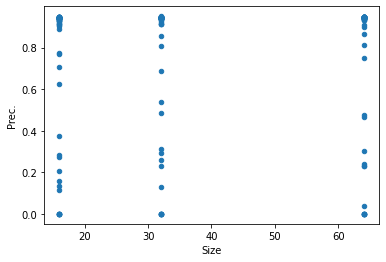

In [46]:
df.plot('Size', 'Prec.', kind='scatter')